In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader

import os
import sys
sys.path.append('Datasets/')
sys.path.append('models/')
import datasets
import models
import audio_utils

from sklearn.metrics import confusion_matrix, classification_report

In [13]:
TUT_TEST_CSV = 'Datasets/TUT18_test.csv'
SCAPPER_TEST_CSV = 'Datasets/scrapper_test_dataset.csv'
TUT_TEST_DF = pd.read_csv(TUT_TEST_CSV)
SCAPPER_TEST_DF = pd.read_csv(SCAPPER_TEST_CSV)
TUT_AUD_DIR = '../audioData/TUTUrban2018/developmentDataset/TUT-urban-acoustic-scenes-2018-development/'
SCAPPER_AUD_DIR = '../audioData/sythenticSoundscenes/train/'

tut_scene_labels = TUT_TEST_DF['labels'].unique()
scapper_scene_labels = SCAPPER_TEST_DF['acoustic_scene_label'].unique()

In [14]:
#MODEL_STATEDICT_PATH = 'ASC_Model00_tut_30epochs_00_statedict.pt'
MODEL_STATEDICT_PATH = 'ASC_Model01_tut_20epochs_sr32000_statedict.pt'
model = models.ASC_Model00(return_second_last=False)
model.load_state_dict(torch.load(MODEL_STATEDICT_PATH))

<All keys matched successfully>

In [69]:
def zero_signal(log_mel, index=2):
    log_mel[0][index] = torch.ones(log_mel[0][index].shape) * log_mel.min()
    return log_mel

In [15]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
tru = []
pred = []

for i, row in TUT_TEST_DF.iterrows():
    audio_file = os.path.join(TUT_AUD_DIR, row['files'])
    audio = audio_utils.load_audio_from_file(audio_file, sample_rate=32000)
    log_mel_spectro = audio_utils.get_log_melSpectrogram(audio)
    

    model.eval()
    with torch.inference_mode():
        log_mel_spectro = log_mel_spectro.to(device)
        out = model(log_mel_spectro.unsqueeze(0))
        out = tut_scene_labels[torch.argmax(torch.sigmoid(out.cpu()))]
    tru.append(row['labels'])
    pred.append(out)

In [55]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
tru = []
pred = []

for i, row in TUT_TEST_DF.iterrows():
    audio_file = os.path.join(TUT_AUD_DIR, row['files'])
    audio = audio_utils.load_audio_from_file(audio_file)
    log_mel_spectro = audio_utils.get_log_melSpectrogram(audio)

    model.eval()
    with torch.inference_mode():
        log_mel_spectro = log_mel_spectro.to(device)
        out = model(log_mel_spectro.unsqueeze(0))
        out = tut_scene_labels[torch.argmax(torch.sigmoid(out.cpu()))]
    tru.append(row['labels'])
    pred.append(out)

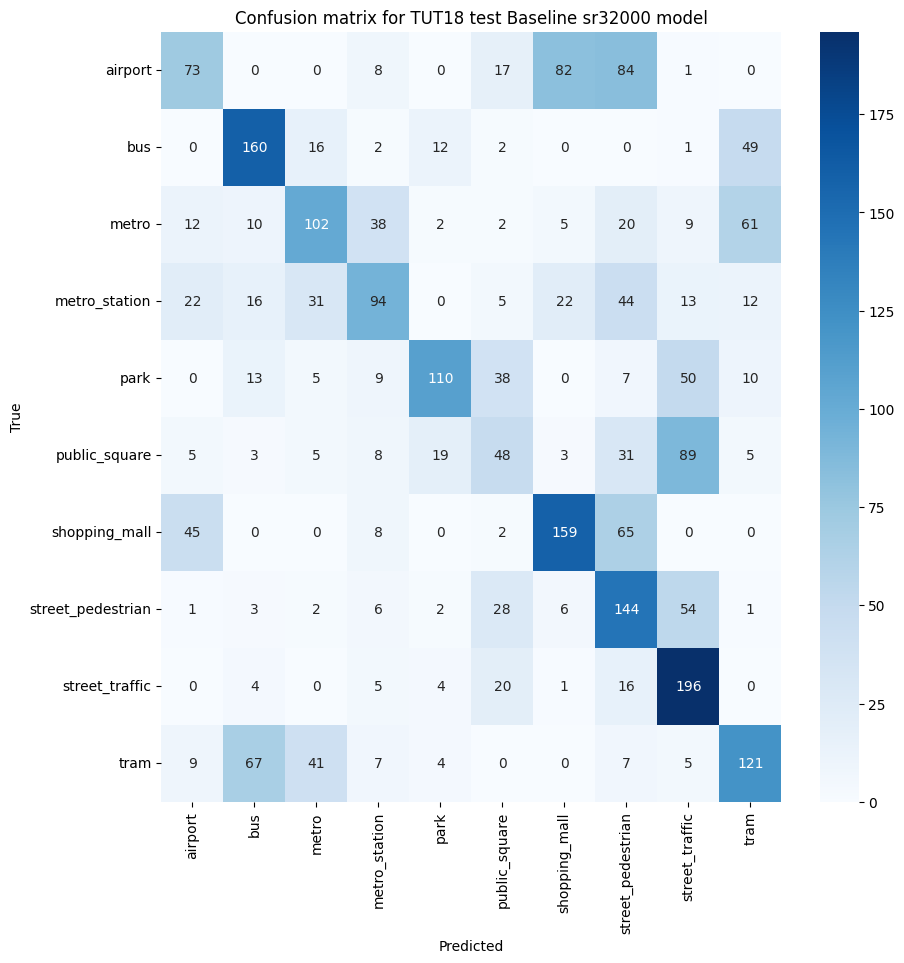

In [16]:
cm = confusion_matrix(tru, pred)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tut_scene_labels, yticklabels=tut_scene_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for TUT18 test Baseline sr32000 model')
plt.show()

In [18]:
pd.DataFrame(classification_report(tru, pred, target_names=tut_scene_labels, output_dict=True)).to_csv('predictions/tut18_test_baseline_sr32000_report.csv')
#pd.DataFrame(classification_report(tru, pred, target_names=scapper_scene_labels, output_dict=True))
#pd.DataFrame(classification_report(tru, pred, target_names=tut_scene_labels, output_dict=True)).to_csv('predictions/scapper_test_baseline_sr32000_report.csv')

In [8]:
SCAPPER_TEST_DF['preds'] = pred
SCAPPER_TEST_DF.to_csv('predictions/scrapper_test_baseline_sr32000.csv', index=False)

In [61]:
pd.read_csv('predictions/TUT18_test_baseline_report.csv')

,Unnamed: 0,airport,bus,metro,metro_station,park,public_square,shopping_mall,street_pedestrian,street_traffic,tram,accuracy,macro avg,weighted avg
0,precision,0.555205,0.597222,0.407285,0.473958,0.753333,0.273913,0.631720,0.396135,0.483776,0.492228,0.504766,0.506478,0.509834
1,recall,0.664151,0.533058,0.471264,0.351351,0.466942,0.291667,0.842294,0.331984,0.666667,0.363985,0.504766,0.498336,0.504766
2,f1-score,0.604811,0.563319,0.436945,0.403548,0.576531,0.282511,0.721966,0.361233,0.560684,0.418502,0.504766,0.493005,0.497821
3,support,265.000000,242.000000,261.000000,259.000000,242.000000,216.000000,279.000000,247.000000,246.000000,261.000000,0.504766,2518.000000,2518.000000


In [64]:
TUT_TEST_DF['preds'] = pred

In [65]:
TUT_TEST_DF.to_csv('predictions/TUT18_test_baseline+10e_predictions.csv', index=False)

In [50]:
TUT_TEST_DF['preds'] = pred
TUT_TEST_DF.to_csv('predictions/TUT18_test_baseline_predictions.csv', index=False)